# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
from utils import get_dataset
import glob
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import tensorflow as tf

%matplotlib inline

In [2]:
dataset_glob_path = "/home/workspace/data/train/*.tfrecord"
dataset = get_dataset(dataset_glob_path)

INFO:tensorflow:Reading unweighted datasets: ['/home/workspace/data/train/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/home/workspace/data/train/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 86
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


## Write a function to display an image and the bounding boxes

Implement the `display_images` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [ ]:
def display_images(batch):
    """
    This function takes a batch from the dataset and displays the image with 
    the associated bounding boxes.
    """
    rgb_mapping = { 1: 'red',   # Vehicles
                    2: 'green', # Cyclists
                    4: 'blue'   # Pedestrians
                  }

    col, row = 5, 2
    _, ax = plt.subplots(col, row, figsize=(36, 36))
    for n, batch_data in enumerate(batch):
        x = n % col
        y = n % row
        # Parse out display information
        bboxes = batch_data['groundtruth_boxes'].numpy()
        classes = batch_data['groundtruth_classes'].numpy()
        img = batch_data['image']
        img_height, img_width, _ = img.shape

        # Display the batch image
        ax[x, y].imshow(img)
    
        # Normalize the bounding boxes to the current image size
        normalized_bboxes = copy.deepcopy(bboxes)
        normalized_bboxes[:, (0, 2)] = bboxes[:, (0, 2)] * img_height
        normalized_bboxes[:, (1, 3)] = bboxes[:, (1, 3)] * img_width

        # Draw the bounding box with the correct coloring based on the class
        for bb, cl in zip (normalized_bboxes, classes):
            y1, x1, y2, x2 = bb
            anchor_point = (x1, y1)
            bb_w =  x2 - x1
            bb_h = y2 - y1
            rec = patches.Rectangle(anchor_point, bb_w, bb_h, facecolor='none', edgecolor=rgb_mapping[cl])
            ax[x, y].add_patch(rec)
        ax[x, y].axis('off')
    plt.tight_layout()
    plt.show()

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

In [ ]:
# Display 10 random images in dataset
rand_dataset = dataset.shuffle(1000)
display_images(dataset.take(10))

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

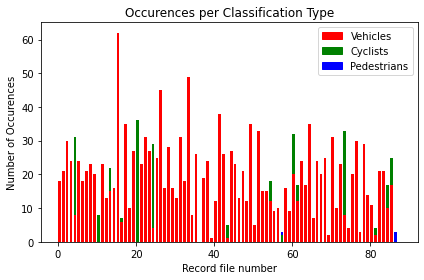

In [3]:
def get_occurence_metrics(batch_data):
    """
    This function takes the batch_data from the dataset and creates a distribution
    bar plot based on the image classifcation.
    """
    num_occurences = { 1: 0, # Vehicles
                       2: 0, # Cyclists
                       4: 0  # Pedestrians
                     }
    class_labels = [("r", "Vehicles"), ("g", "Cyclists"), ("b", "Pedestrians")]
    total_records_num_occurrences = list()
    # For each tfrecord, calculate the total number of occurences
    for i, batch in enumerate(batch_data):
        classes = batch['groundtruth_classes'].numpy()
        # Total up the number of occurences per class
        for cl in classes:
            num_occurences[cl] += 1
        # Save off the record's occurences
        total_records_num_occurrences.append(num_occurences.copy())
        # Reset the number of occurences
        for i in num_occurences:
            num_occurences[i] = 0
    
    # Prep the subplots
    _, ax = plt.subplots()
    num_classes = len(num_occurences)
    bar_width = 0.7
    # For every record, add a bar for each classification indicating the total number
    # of occurrences in an image 
    for i, occurrence in enumerate(total_records_num_occurrences):
        for j, n in enumerate(occurrence):
            ax.bar(i + j, occurrence[n], bar_width, color=class_labels[j][0], align="edge")

    # Create the plot labels
    ax.set_title("Occurences per Classification Type")
    ax.set_ylabel("Number of Occurences")
    ax.set_xlabel("Record file number")
    # Create a pretty legend
    handles = [plt.Rectangle((0 , 0), 1, 1, color=l[0]) for l in class_labels]
    ax.legend(handles, [label[1] for label in class_labels])
    plt.tight_layout()
    # Display the results in a bar plot
    plt.show()

# Draw the occurence metrics bar plot
get_occurence_metrics(dataset.take(86))